## Section1: Self coding day for:
A.First PCA, Second Clustering

B.First Clustering, Second PCA.
## Section2: Assignment 2. Answer to Q1, Q2, and Q3.

## A: First PCA, Second Clustering.
Here we use PCA to reduce featrues. Output of PCA will be some number of principal components. Using the components, we will perform clustering analysis.
Step:
First, use the N of principal components that expalins 90 % of total variable in the data.
Second, Do clustering analysis with the N of principal components.
Thrid, Visualize the clustering

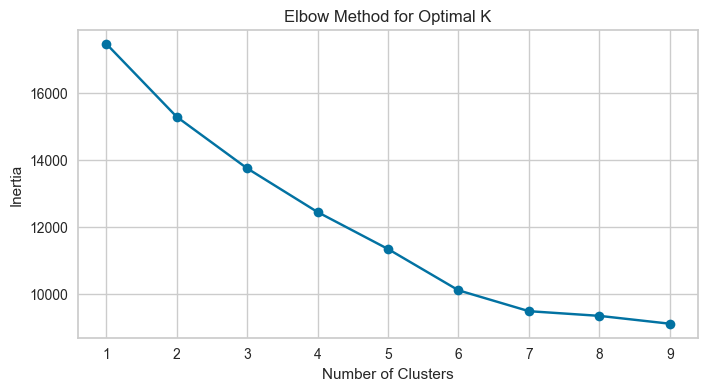

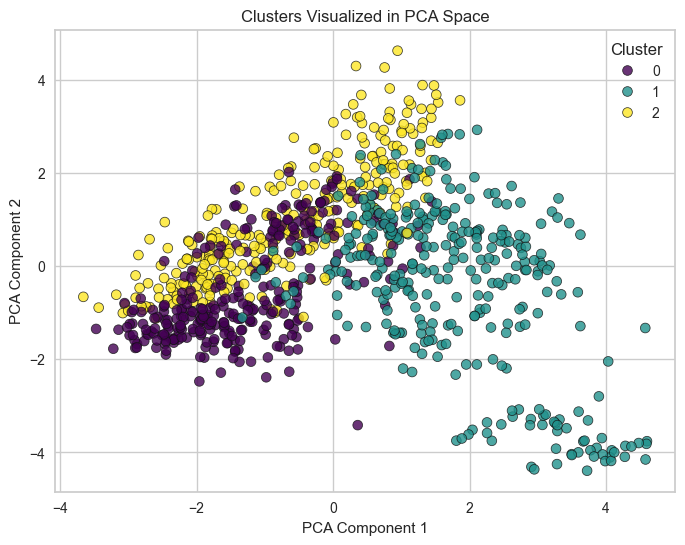

In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Load and Prepare the Dataset
# ============================
data = pd.read_csv('heart_disease_uci.csv')

# Drop 'id' if it exists
data.drop(columns=['id'], errors='ignore', inplace=True)

# Rename 'num' column to 'Heart_Disease_Stage'
data.rename({'num': 'Heart_Disease_Stage'}, axis=1, inplace=True)

# Replace spaces in column names with underscores
data.columns = data.columns.str.replace(' ', '_')

# ============================
# One-Hot Encoding for Categorical Variables
# ============================
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Fill NaN values with 0 before converting to int
data_encoded = data_encoded.fillna(0)

# ============================
# Standardize Features (Excluding Target)
# ============================
X = data_encoded.drop(columns=['Heart_Disease_Stage'])  # Features
y = data_encoded['Heart_Disease_Stage']  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
# Perform PCA: Keep Components Explaining 90% Variance
# ============================
pca = PCA(n_components=0.90)  # Keep enough PCs to explain 90% variance
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# ============================
# Perform Clustering on PCA-Reduced Data
# ============================

# Determine optimal K using the Elbow Method
inertia = []
K = range(1, 10)  # Testing K from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_df)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Fit K-Means with the best K (adjust based on elbow plot)
optimal_k = 3  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_pca_df['Cluster'] = kmeans.fit_predict(X_pca_df)

# ============================
# Visualize Clusters in PCA Space
# ============================

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_df.iloc[:, 0], y=X_pca_df.iloc[:, 1], hue=X_pca_df['Cluster'], palette='viridis', alpha=0.8, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualized in PCA Space")
plt.legend(title="Cluster")
plt.show()


## B.First Clustering, Second PCA

This time, let`s breakt down the code.

## 1. Clustering + PCA

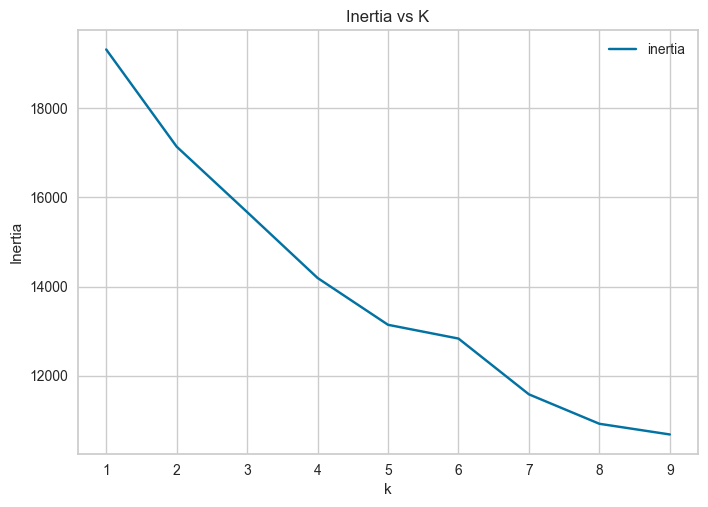

Analysis: It's not obvious where the elbow is (maybe 5 or 7?) so I'll use yellowbrick to select K


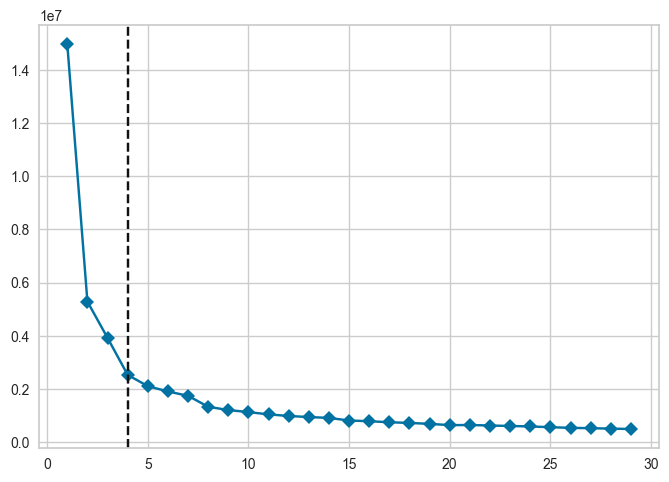

Analysis: Based on this plot, it appears that the optimal K is 4.
I'll use the yellowbricks selection going forward.


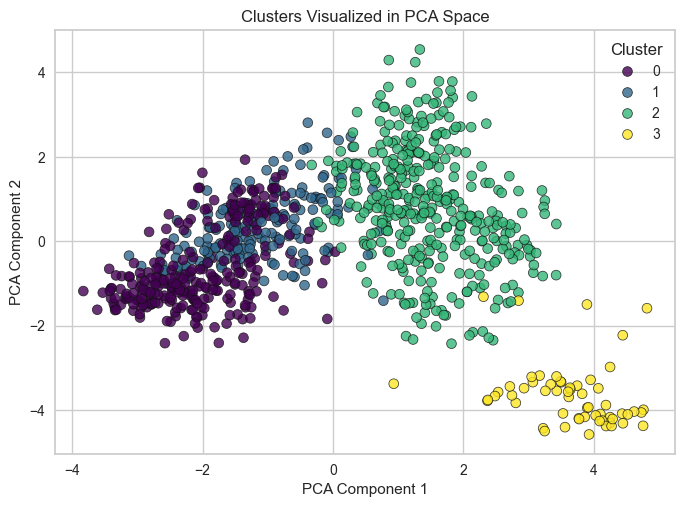


Notes:  
1) Although cluster was provided as a feature to the PCA, 
it appears that PCA1 and PCA2 were nearly identical.
2) The clusterings apper to be slightly higher quality than the preceeding example.
Visually, k=4 seems to be a better fit for the data. 



In [112]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# ============================
# Load and Prepare the Dataset
# ============================
data = pd.read_csv('heart_disease_uci.csv').set_index('id')

# Rename 'num' column to 'Heart_Disease_Stage'
data.rename({'num': 'Heart_Disease_Stage'}, axis=1, inplace=True)

# Replace spaces in column names with underscores
data.columns = data.columns.str.replace(' ', '_')

# ============================
# One-Hot Encoding for Categorical Variables
# ============================
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Fill

### Data Prep
# Handle missing data
data_encoded = data_encoded.fillna(0)

# Split into X and remove the target varible
X = data_encoded.drop(columns=['Heart_Disease_Stage'])

# Standardize/normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

### Clustering
# Get optimal K
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append({
        'k': k,
        'inertia': kmeans.inertia_
    })
inertia_df = pd.DataFrame(data=inertia, columns=['k', 'inertia']).set_index('k')
ax = inertia_df.plot()
ax.set_title('Inertia vs K')
ax.set_xlabel('k')
ax.set_ylabel('Inertia')
plt.show()
print("Analysis: It's not obvious where the elbow is (maybe 5 or 7?) so I'll use yellowbrick to select K")

## Find optimal K with yellowbrick
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 30), metric='distortion', timings=False)
visualizer.fit(data_encoded)
plt.show()
print("Analysis: Based on this plot, it appears that the optimal K is 4.")
print("I'll use the yellowbricks selection going forward.")

# Run KMeans for best k and save clusters and assign clusters
kmeans = KMeans(n_clusters=4, random_state=42)
X_scaled_df['Cluster'] = kmeans.fit_predict(X_scaled_df)

### PCA
# I use PCA to see which features most impact Y (explain X percent of variance)
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled_df)
X_pca_df = pd.DataFrame(
    X_pca, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_scaled_df.columns
)

## VISUALIZE
# Plot Principal Component (PC) 1 vs PC 2 with cluster assignment
sns.scatterplot(
    x=X_pca_df.iloc[:, 0], 
    y=X_pca_df.iloc[:, 1], 
    hue=X_scaled_df['Cluster'], 
    palette='viridis', 
    alpha=0.8, 
    edgecolor='k'
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualized in PCA Space")
plt.legend(title="Cluster")
plt.show()

print("""
Notes:  
1) Although cluster was provided as a feature to the PCA, 
it appears that PCA1 and PCA2 were nearly identical.
2) The clusterings apper to be slightly higher quality than the preceeding example.
Visually, k=4 seems to be a better fit for the data. 
""")


## Load the dataset

Column Descriptions:
id (Unique id for each patient)

age (Age of the patient in years)

origin (place of study)

sex (Male/Female)

cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])

trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))

chol (serum cholesterol in mg/dl)

fbs (if fasting blood sugar > 120 mg/dl)

restecg (resting electrocardiographic results)

-- Values: [normal, stt abnormality, lv hypertrophy]
thalach: maximum heart rate achieved

exang: exercise-induced angina (True/ False)

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by fluoroscopy

thal: [normal; fixed defect; reversible defect]

num: the predicted attribu

# Report source of data, N of rows and, variables you use in the analysis

In [113]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
# Load the dataset:  https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
data = pd.read_csv('heart_disease_uci.csv')

# Change variable name num to Heart_Disease_Stage
data.rename({'num': 'Heart_Disease_Stage'}, axis=1, inplace=True)

# Replace spaces in all column names with underscores
data.columns = data.columns.str.replace(' ', '_')

print(data.shape)
data.head()

(920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Heart_Disease_Stage
0,1,63,Male,Cleveland,typical angina,145.000000,233.000000,True,lv hypertrophy,150.000000,False,2.300000,downsloping,0.000000,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.000000,286.000000,False,lv hypertrophy,108.000000,True,1.500000,flat,3.000000,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.000000,229.000000,False,lv hypertrophy,129.000000,True,2.600000,flat,2.000000,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.000000,250.000000,False,normal,187.000000,False,3.500000,downsloping,0.000000,normal,0
4,5,41,Female,Cleveland,atypical angina,130.000000,204.000000,False,lv hypertrophy,172.000000,False,1.400000,upsloping,0.000000,normal,0


## Data Pre-processing.

# Report variable descriptions, statistics, and unique values for categorical variables. If too many lables (values), you report few. The goal is to explain the data you have. Here, we skip many parts, but just check the unique value for each variable.

In [114]:
for column in data:
    unique_vals = np.unique(data[column].astype(str))  # pring NaN as character.
    nr_values = len(unique_vals)                       # count for numerical variables
    if nr_values <= 12:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature id :920
The number of values for feature age :50
The number of values for feature sex :2 -- ['Female' 'Male']
The number of values for feature dataset :4 -- ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
The number of values for feature cp :4 -- ['asymptomatic' 'atypical angina' 'non-anginal' 'typical angina']
The number of values for feature trestbps :62
The number of values for feature chol :218
The number of values for feature fbs :3 -- ['False' 'True' 'nan']
The number of values for feature restecg :4 -- ['lv hypertrophy' 'nan' 'normal' 'st-t abnormality']
The number of values for feature thalch :120
The number of values for feature exang :3 -- ['False' 'True' 'nan']
The number of values for feature oldpeak :54
The number of values for feature slope :4 -- ['downsloping' 'flat' 'nan' 'upsloping']
The number of values for feature ca :5 -- ['0.0' '1.0' '2.0' '3.0' 'nan']
The number of values for feature thal :4 -- ['fixed defect' 'nan' 'normal' 

## Check for null values

Given the total Obs (N=920), concerning variables are: c slope, ca, and thal   

In [115]:
data.isnull().sum()

id                       0
age                      0
sex                      0
dataset                  0
cp                       0
trestbps                59
chol                    30
fbs                     90
restecg                  2
thalch                  55
exang                   55
oldpeak                 62
slope                  309
ca                     611
thal                   486
Heart_Disease_Stage      0
dtype: int64

## Handle Missing Values

In [116]:
# Fill numerical columns with their median
numerical_cols = data.select_dtypes(include=[np.number]).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Fill categorical columns with the most frequent value (mode)
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


C:\Users\natha\AppData\Local\Temp\ipykernel_5328\1844787185.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


Data Cleaning for Categorical Variables

In [117]:
# Data Cleaning
data.drop('id', axis=1, inplace=True)  # Drop ID column

# Categorical variables to be one-hot encoded
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'Heart_Disease_Stage']

# One-hot encoding using get_dummies
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False).astype(int)

# Replace spaces in all column names with underscores
data_encoded.columns = data_encoded.columns.str.replace(' ', '_')

Check what new variables are created

In [118]:
print("Updated Column Names:", data.columns.tolist())

Updated Column Names: ['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'Heart_Disease_Stage']


In [119]:
# Print the updated column names
print("Updated Column Names:", data_encoded.columns.tolist())

Updated Column Names: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'sex_Female', 'sex_Male', 'dataset_Cleveland', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA_Long_Beach', 'cp_asymptomatic', 'cp_atypical_angina', 'cp_non-anginal', 'cp_typical_angina', 'fbs_False', 'fbs_True', 'restecg_lv_hypertrophy', 'restecg_normal', 'restecg_st-t_abnormality', 'exang_False', 'exang_True', 'slope_downsloping', 'slope_flat', 'slope_upsloping', 'thal_fixed_defect', 'thal_normal', 'thal_reversable_defect', 'Heart_Disease_Stage_0', 'Heart_Disease_Stage_1', 'Heart_Disease_Stage_2', 'Heart_Disease_Stage_3', 'Heart_Disease_Stage_4']


In [120]:
data_encoded.head()

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect,Heart_Disease_Stage_0,Heart_Disease_Stage_1,Heart_Disease_Stage_2,Heart_Disease_Stage_3,Heart_Disease_Stage_4
0,63,145,233,150,2,0,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0
1,67,160,286,108,1,3,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
2,67,120,229,129,2,2,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
3,37,130,250,187,3,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
4,41,130,204,172,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0


## Standardize numerical variables (Features)

In [121]:
# Define numerical variables to standardize
numerical_vars = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Initialize StandardScaler
scaler = StandardScaler()
# Apply scaling only to the selected numerical columns
data_encoded[numerical_vars] = scaler.fit_transform(data_encoded[numerical_vars])

# Print the first few rows to verify the standardization
print(data_encoded[numerical_vars].head())


        age  trestbps     chol    thalch  oldpeak        ca
0  1.007386  0.705176 0.303643  0.489727 1.326348 -0.361400
1  1.432034  1.518569 0.789967 -1.181478 0.323686  4.411152
2  1.432034 -0.650479 0.266939 -0.345875 1.326348  2.820301
3 -1.752828 -0.108217 0.459634  1.961979 2.329010 -0.361400
4 -1.328180 -0.108217 0.037541  1.365120 0.323686 -0.361400


## Let`s check how the values look like when to scaling instead.

In [122]:

from sklearn.preprocessing import  MinMaxScaler
# Define numerical variables to standardize and scale
numerical_vars = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

scaled_data = data_encoded.copy()

# Apply MinMaxScaler (scaling to [0,1])
scaler_minmax = MinMaxScaler()
scaled_data[numerical_vars] = scaler_minmax.fit_transform(scaled_data[numerical_vars])


scaled_data.head()

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect,Heart_Disease_Stage_0,Heart_Disease_Stage_1,Heart_Disease_Stage_2,Heart_Disease_Stage_3,Heart_Disease_Stage_4
0,0.714286,0.725000,0.386401,0.633803,0.500000,0.000000,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0
1,0.795918,0.800000,0.474295,0.338028,0.375000,1.000000,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
2,0.795918,0.600000,0.379768,0.485915,0.500000,0.666667,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
3,0.183673,0.650000,0.414594,0.894366,0.625000,0.000000,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
4,0.265306,0.650000,0.338308,0.788732,0.375000,0.000000,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0


I am going to use standardization instead of scaling because scaling increases the spread of the data. See the two boxplot below. Since I want to retain the outliers for now, standardization is a better choice. At this stage, I am unsure whether the outliers are meaningful, so I prefer to keep them in the analysis.

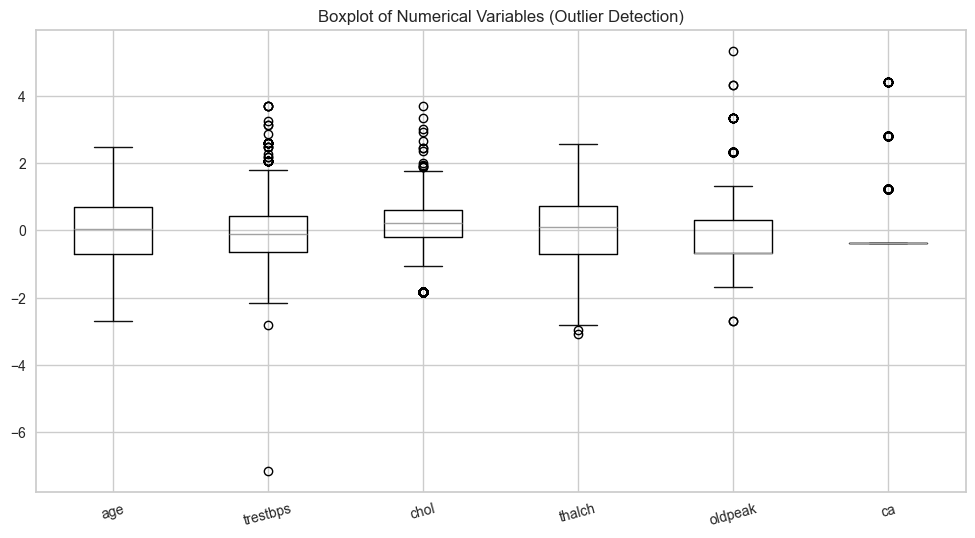

In [123]:
## Standardization and Boxplot##

import matplotlib.pyplot as plt
import seaborn as sns
# Plot boxplots for numerical variables
plt.figure(figsize=(12, 6))
data_encoded[numerical_vars].boxplot()
plt.xticks(rotation=15)
plt.title("Boxplot of Numerical Variables (Outlier Detection)")
plt.show()


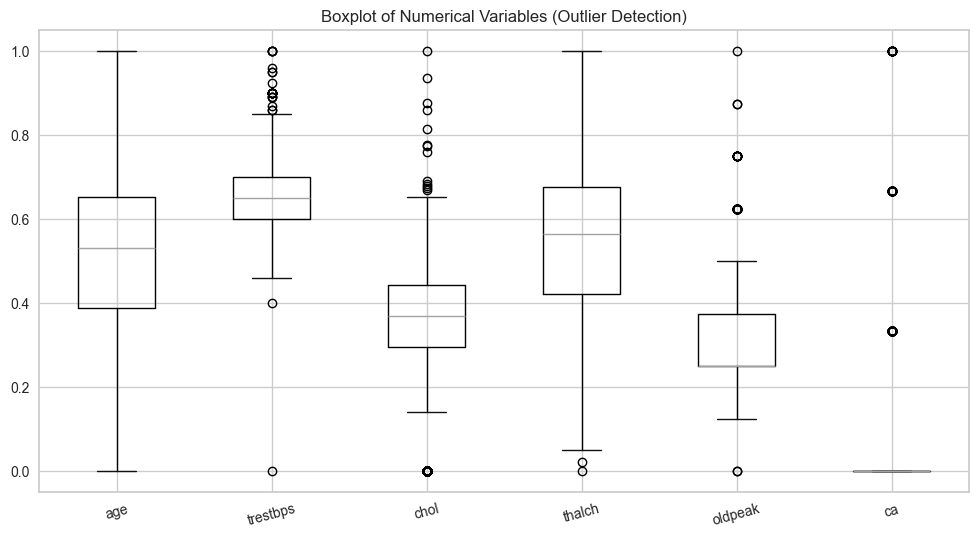

In [124]:
## Scaling & Boxplot##

# Plot boxplots for numerical variables
plt.figure(figsize=(12, 6))
scaled_data[numerical_vars].boxplot()
plt.xticks(rotation=15)
plt.title("Boxplot of Numerical Variables (Outlier Detection)")
plt.show()


## Ok, let`s use Elbow Methods to find the optimized cluster K

In [125]:
data_encoded

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect,Heart_Disease_Stage_0,Heart_Disease_Stage_1,Heart_Disease_Stage_2,Heart_Disease_Stage_3,Heart_Disease_Stage_4
0,1.007386,0.705176,0.303643,0.489727,1.326348,-0.361400,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0
1,1.432034,1.518569,0.789967,-1.181478,0.323686,4.411152,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
2,1.432034,-0.650479,0.266939,-0.345875,1.326348,2.820301,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
3,-1.752828,-0.108217,0.459634,1.961979,2.329010,-0.361400,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
4,-1.328180,-0.108217,0.037541,1.365120,0.323686,-0.361400,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.051927,-0.270895,1.221235,0.648889,-0.678977,-0.361400,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
916,0.901224,-0.108217,-0.558893,0.091821,-0.678977,-0.361400,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0
917,0.158089,-0.542026,0.211884,-1.499803,-0.678977,-0.361400,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
918,0.476575,-0.108217,1.698383,0.091821,-0.678977,-0.361400,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0


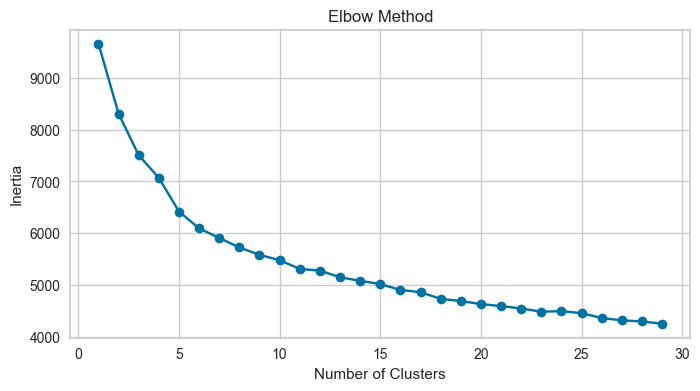

In [126]:
# Elbow Method for Best Number of Clusters
inertia = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_encoded)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

I may argue k= 5, or just used the KElbowVisualizer

,estimator,KMeans(n_clus...ndom_state=42)
,ax,<Axes: >
,k,"(1, ...)"
,metric,'distortion'
,distance_metric,'euclidean'
,timings,False
,locate_elbow,True
,n_clusters,29
,init,'k-means++'
,n_init,'auto'
,max_iter,300


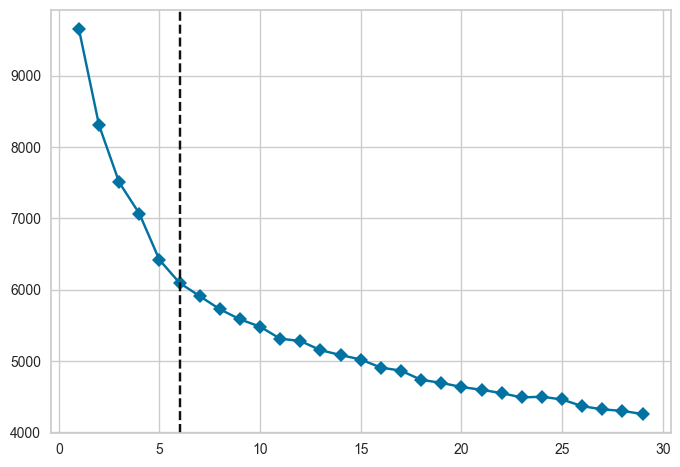

In [127]:
from yellowbrick.cluster import KElbowVisualizer

[ ]
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize KMeans model
model = KMeans(random_state=42)

# Use KElbowVisualizer to find the best number of clusters
visualizer = KElbowVisualizer(model, k=(1, 30), metric='distortion', timings=False)
visualizer.fit(data_encoded)  # Fit the model



## Ok, using k= 5, let`s cluster the data

In [128]:
data_encoded

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect,Heart_Disease_Stage_0,Heart_Disease_Stage_1,Heart_Disease_Stage_2,Heart_Disease_Stage_3,Heart_Disease_Stage_4
0,1.007386,0.705176,0.303643,0.489727,1.326348,-0.361400,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0
1,1.432034,1.518569,0.789967,-1.181478,0.323686,4.411152,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
2,1.432034,-0.650479,0.266939,-0.345875,1.326348,2.820301,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
3,-1.752828,-0.108217,0.459634,1.961979,2.329010,-0.361400,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
4,-1.328180,-0.108217,0.037541,1.365120,0.323686,-0.361400,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.051927,-0.270895,1.221235,0.648889,-0.678977,-0.361400,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
916,0.901224,-0.108217,-0.558893,0.091821,-0.678977,-0.361400,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0
917,0.158089,-0.542026,0.211884,-1.499803,-0.678977,-0.361400,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
918,0.476575,-0.108217,1.698383,0.091821,-0.678977,-0.361400,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0


In [129]:
# Run K-means
optimal_clusters = 5  # Based on elbow/dendrogram
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_encoded['Cluster'] = kmeans.fit_predict(data_encoded)
data_encoded.head()


,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect,Heart_Disease_Stage_0,Heart_Disease_Stage_1,Heart_Disease_Stage_2,Heart_Disease_Stage_3,Heart_Disease_Stage_4,Cluster
0,1.007386,0.705176,0.303643,0.489727,1.326348,-0.361400,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
1,1.432034,1.518569,0.789967,-1.181478,0.323686,4.411152,0,1,1,0,...,0,0,1,0,0,0,1,0,0,3
2,1.432034,-0.650479,0.266939,-0.345875,1.326348,2.820301,0,1,1,0,...,0,0,0,1,0,1,0,0,0,3
3,-1.752828,-0.108217,0.459634,1.961979,2.329010,-0.361400,0,1,1,0,...,0,0,1,0,1,0,0,0,0,4
4,-1.328180,-0.108217,0.037541,1.365120,0.323686,-0.361400,1,0,1,0,...,1,0,1,0,1,0,0,0,0,4


## use PCA

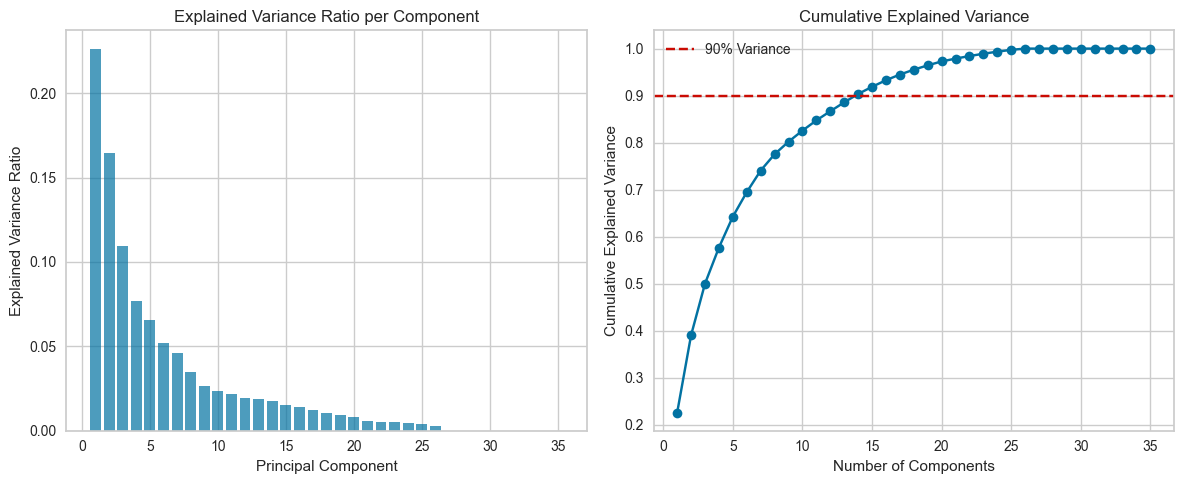

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(data_encoded)

# Explained Variance Ratio (Individual & Cumulative)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot: Explained Variance for Each Component
plt.figure(figsize=(12, 5))

# Subplot 1: Individual Explained Variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Component')

# Subplot 2: Cumulative Explained Variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(data_encoded)

# Explained Variance Ratio (Individual & Cumulative)
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance_ratio)  # Cumulative sum

# Create DataFrame to display explained variance percentages
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio (%)': explained_variance_ratio,
    'Cumulative Explained Variance (%)': cumulative_variance
})

# Turn off scientific notation for printing
pd.options.display.float_format = '{:.6f}'.format

# Display explained variance values
print(explained_variance_df)


   Principal Component  Explained Variance Ratio (%)  \
0                  PC1                     22.584378   
1                  PC2                     16.464674   
2                  PC3                     10.962204   
3                  PC4                      7.670774   
4                  PC5                      6.580665   
5                  PC6                      5.208684   
6                  PC7                      4.589800   
7                  PC8                      3.470517   
8                  PC9                      2.665044   
9                 PC10                      2.356719   
10                PC11                      2.175016   
11                PC12                      1.944438   
12                PC13                      1.892209   
13                PC14                      1.783931   
14                PC15                      1.519828   
15                PC16                      1.403610   
16                PC17                      1.20

The sum of the Explained Variance Ratio for the first two principal components (PC1 + PC2) is about 40%. While this does not preserve all the original information, plotting our clusters on the new coordinate system formed by PC1 and PC2 can still provide a rough idea of the clustering structure.

In [132]:
data_encoded

,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect,Heart_Disease_Stage_0,Heart_Disease_Stage_1,Heart_Disease_Stage_2,Heart_Disease_Stage_3,Heart_Disease_Stage_4,Cluster
0,1.007386,0.705176,0.303643,0.489727,1.326348,-0.361400,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
1,1.432034,1.518569,0.789967,-1.181478,0.323686,4.411152,0,1,1,0,...,0,0,1,0,0,0,1,0,0,3
2,1.432034,-0.650479,0.266939,-0.345875,1.326348,2.820301,0,1,1,0,...,0,0,0,1,0,1,0,0,0,3
3,-1.752828,-0.108217,0.459634,1.961979,2.329010,-0.361400,0,1,1,0,...,0,0,1,0,1,0,0,0,0,4
4,-1.328180,-0.108217,0.037541,1.365120,0.323686,-0.361400,1,0,1,0,...,1,0,1,0,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.051927,-0.270895,1.221235,0.648889,-0.678977,-0.361400,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
916,0.901224,-0.108217,-0.558893,0.091821,-0.678977,-0.361400,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
917,0.158089,-0.542026,0.211884,-1.499803,-0.678977,-0.361400,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
918,0.476575,-0.108217,1.698383,0.091821,-0.678977,-0.361400,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1


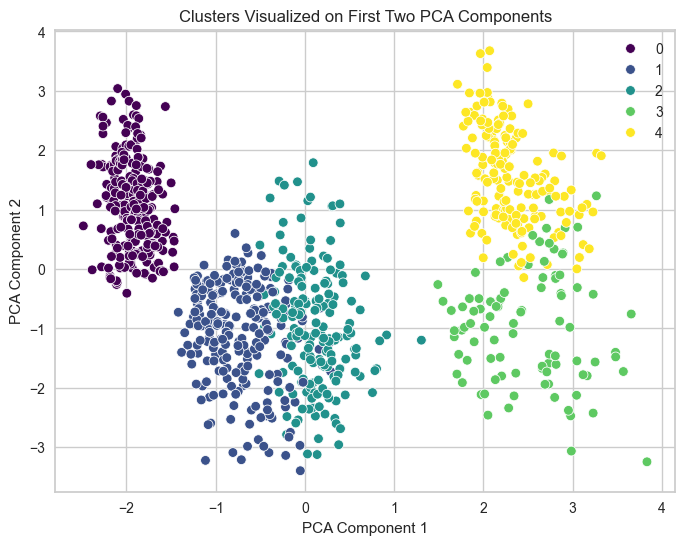

In [133]:
# Visualize Clusters
pca_2d = pca_features[:, :2]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=data_encoded['Cluster'], palette='viridis')
plt.title('Clusters Visualized on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

To determine which variable contributes the most to Principal Component 1 (PC1) in PCA, we examine the PCA component loadings (eigenvectors).The feature with the highest loading (absolute value) in PC1 is the most influential in determining PC1.

Positive loadings (e.g., 0.2): The feature positively correlates with the principal component.

Negative loadings (e.g., -0.2): The feature negatively correlates with the principal component.

Higher absolute values (e.g., 0.7 or -0.8): The feature strongly influences the component.

Lower absolute values (e.g., 0.05): The feature has little influence on that component.

In [134]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(data_encoded)

print(data_encoded.columns)

# Create a DataFrame for PCA Loadings
loadings_df = pd.DataFrame(
    pca.components_,  # PCA loadings (eigenvectors)
    columns=data_encoded.columns,  # Original feature names
    index=[f'PC{i+1}' for i in range(len(pca.components_))]  # Naming PCs
)

# Identify the feature with the highest absolute contribution to PC1
top_feature_pc1 = loadings_df.loc['PC1'].abs().idxmax()

# Print PCA loadings and top contributor to PC1
print("PCA Loadings for PC1:")
print(loadings_df.loc['PC1'])
print(f"\nFeature with highest contribution to PC1: {top_feature_pc1}")


Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'sex_Female',
       'sex_Male', 'dataset_Cleveland', 'dataset_Hungary',
       'dataset_Switzerland', 'dataset_VA_Long_Beach', 'cp_asymptomatic',
       'cp_atypical_angina', 'cp_non-anginal', 'cp_typical_angina',
       'fbs_False', 'fbs_True', 'restecg_lv_hypertrophy', 'restecg_normal',
       'restecg_st-t_abnormality', 'exang_False', 'exang_True',
       'slope_downsloping', 'slope_flat', 'slope_upsloping',
       'thal_fixed_defect', 'thal_normal', 'thal_reversable_defect',
       'Heart_Disease_Stage_0', 'Heart_Disease_Stage_1',
       'Heart_Disease_Stage_2', 'Heart_Disease_Stage_3',
       'Heart_Disease_Stage_4', 'Cluster'],
      dtype='object')
PCA Loadings for PC1:
age                         0.181838
trestbps                    0.007999
chol                       -0.008953
thalch                      0.146283
oldpeak                     0.075266
ca                          0.341809
sex_Female                  0.

In [135]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(data_encoded)

# Create a DataFrame for PCA Loadings
loadings_df = pd.DataFrame(
    pca.components_,  # PCA loadings (eigenvectors)
    columns=data_encoded.columns,  # Original feature names
    index=[f'PC{i+1}' for i in range(len(pca.components_))]  # Naming PCs
)

# Identify the feature with the highest absolute contribution to PC1
top_feature_pc2 = loadings_df.loc['PC2'].abs().idxmax()

# Print PCA loadings and top contributor to PC1
print("PCA Loadings for PC2:")
print(loadings_df.loc['PC2'])
print(f"\nFeature with highest contribution to PC2: {top_feature_pc2}")

PCA Loadings for PC2:
age                        -0.452611
trestbps                   -0.262503
chol                        0.187396
thalch                      0.516653
oldpeak                    -0.385424
ca                         -0.113202
sex_Female                  0.077854
sex_Male                   -0.077854
dataset_Cleveland           0.073603
dataset_Hungary             0.084184
dataset_Switzerland        -0.059122
dataset_VA_Long_Beach      -0.098666
cp_asymptomatic            -0.178906
cp_atypical_angina          0.110048
cp_non-anginal              0.060760
cp_typical_angina           0.008097
fbs_False                   0.040123
fbs_True                   -0.040123
restecg_lv_hypertrophy     -0.000793
restecg_normal              0.059613
restecg_st-t_abnormality   -0.058820
exang_False                 0.188634
exang_True                 -0.188634
slope_downsloping          -0.040687
slope_flat                 -0.045731
slope_upsloping             0.086418
thal_fixed_defec

## #. Assignment 2: Clustering and PCA

##Q1. We can see the Cluster dominates the principal component 1. It is useful to include Cluster as feature to do PCA to check if clusters are clearly separated in PC1 & PC2. But, what are we missing by adding 'Cluster' when doing PCA? What it means if we exclude the Cluster in our PCA analysis?

**Your Answer:**

Since the cluster is derived from information already contained in the model, it's biasing the existing results rather than adding to them.  This creates results that look better, but only because the cluster is affirming the trends in the data.  Overall, adding cluster will emphasize the elements that contribute most to the cluster choices while reducing the scale of less impactful components.
 

## THis time, we eclude Cluster for PCA but only keep it for plotting

Explained Variance Ratio (in %):
   Principal Component  Explained Variance Ratio (%)  \
0                  PC1                     19.797201   
1                  PC2                     14.470973   
2                  PC3                     10.232755   
3                  PC4                      9.072314   
4                  PC5                      7.274988   
5                  PC6                      6.115023   
6                  PC7                      4.260895   
7                  PC8                      3.585028   
8                  PC9                      3.141091   
9                 PC10                      2.793422   
10                PC11                      2.558428   
11                PC12                      2.282032   
12                PC13                      2.187490   
13                PC14                      2.096988   
14                PC15                      1.702785   
15                PC16                      1.532769   
16             

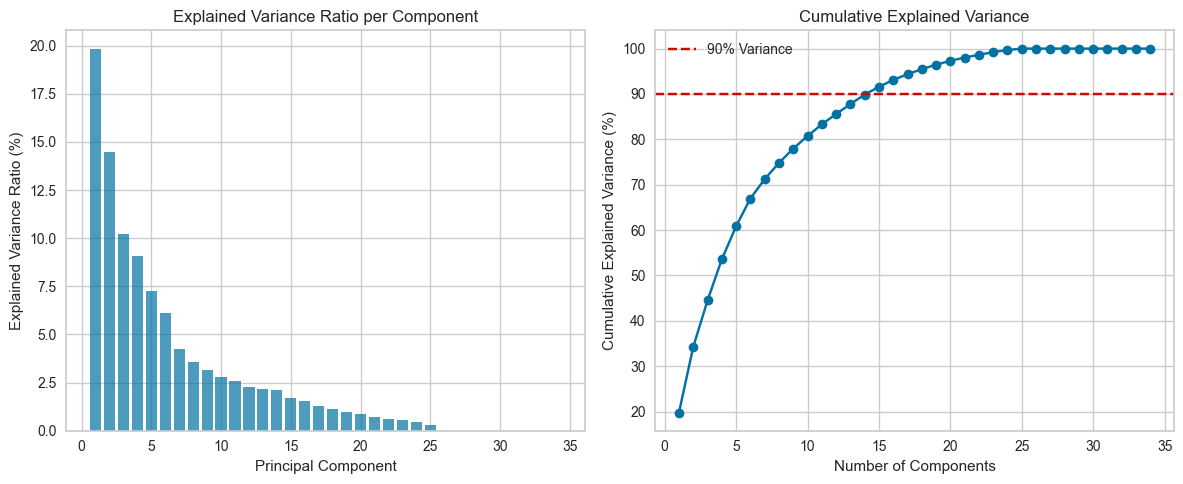

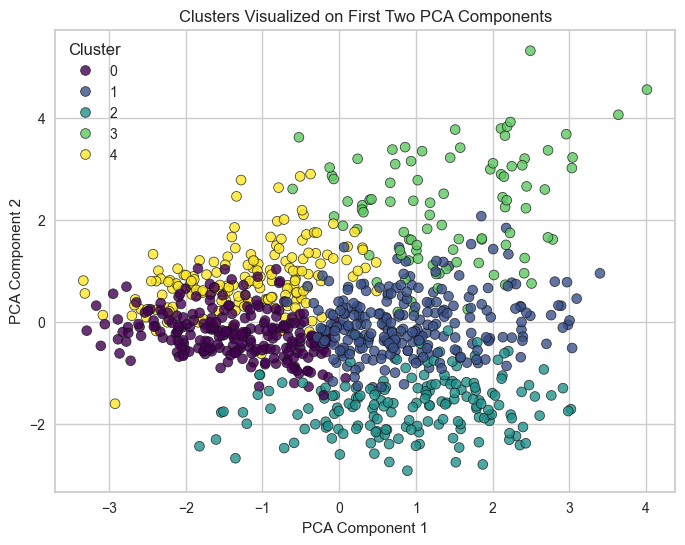

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# ============================
# Exclude 'Cluster' for PCA but keep it for plotting
# ============================

# Store Cluster labels separately
cluster_labels = data_encoded['Cluster']  # Store for visualization
pca_data = data_encoded.drop(columns=['Cluster'], errors='ignore')  # Exclude Cluster for PCA

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(pca_data)

# ============================
# Explained Variance Ratio (Individual & Cumulative)
# ============================

explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance_ratio)  # Cumulative sum

# Create DataFrame to display explained variance percentages
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio (%)': explained_variance_ratio,
    'Cumulative Explained Variance (%)': cumulative_variance
})

# Turn off scientific notation for printing
pd.options.display.float_format = '{:.6f}'.format

# Display explained variance values
print("Explained Variance Ratio (in %):")
print(explained_variance_df)

# ============================
# Plot: Explained Variance for Each Component
# ============================

plt.figure(figsize=(12, 5))

# Subplot 1: Individual Explained Variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio (%)')
plt.title('Explained Variance Ratio per Component')

# Subplot 2: Cumulative Explained Variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=90, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

# ============================
# Visualize Clusters in PCA Space
# ============================

pca_2d = pca_features[:, :2]  # Use first two principal components

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=cluster_labels, palette='viridis', alpha=0.8, edgecolor='k')
plt.title('Clusters Visualized on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


Compute PCA Loadings and identify the most influential feature for PC1, while ensuring Cluster is excluded before PCA computation.

In [137]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# ============================
# Exclude 'Cluster' from PCA
# ============================
pca_data = scaled_data.drop(columns=['Cluster'], errors='ignore')  # Ensure Cluster is not included

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(pca_data)

# ============================
# PCA Loadings (Feature Contributions to PCs)
# ============================

# Create a DataFrame for PCA Loadings
loadings_df = pd.DataFrame(
    pca.components_,  # PCA loadings (eigenvectors)
    columns=pca_data.columns,  # Original feature names (excluding Cluster)
    index=[f'PC{i+1}' for i in range(len(pca.components_))]  # Naming PCs
)

# Identify the feature with the highest absolute contribution to PC1
top_feature_pc1 = loadings_df.loc['PC1'].abs().idxmax()

# ============================
# Display PCA Loadings & Top Contributor to PC1
# ============================
print("PCA Loadings for PC1:")
print(loadings_df.loc['PC1'])
print(f"\nFeature with highest contribution to PC1: {top_feature_pc1}")


PCA Loadings for PC1:
age                        -0.066594
trestbps                   -0.013777
chol                        0.044688
thalch                      0.090120
oldpeak                    -0.054234
ca                         -0.027729
sex_Female                  0.193339
sex_Male                   -0.193339
dataset_Cleveland           0.059899
dataset_Hungary             0.166249
dataset_Switzerland        -0.095944
dataset_VA_Long_Beach      -0.130205
cp_asymptomatic            -0.382714
cp_atypical_angina          0.216404
cp_non-anginal              0.142532
cp_typical_angina           0.023778
fbs_False                   0.055482
fbs_True                   -0.055482
restecg_lv_hypertrophy     -0.024470
restecg_normal              0.094103
restecg_st-t_abnormality   -0.069633
exang_False                 0.378600
exang_True                 -0.378600
slope_downsloping          -0.050101
slope_flat                 -0.049053
slope_upsloping             0.099154
thal_fixed_defec

##Q2ab. Further, think what it means if you **Exclude** Heart_Disease_Stage_n (Ideally, excluding these varaibles when computing Clusters as well).

##So, a) what can we investigate by excluding Heart_Disease_Stage when doing clustering analysis and PCA? Can we link the clustering and PCA results with  Heart_Disease_Stage?

## b) Discuss your findings in less than 400 words (You will need to do Q3 and additional anlyses to answer this).

tip: you may not need to make dummies for Heart_Disease_stage because it is ordinal.

**Your Answer:**

a) By removing Heart_Disease_Stage, we can use it is a target varible for training or assessing it's connecting to the PCAs or clusters.  

b) Question 3's clustering appears to be far more meaningful than the previous examples.  My assumption is that Heart_Desease_Stage and Cluster (where included) where decreasing ability of PCA to find the most meanful features, perhaps because it's closely related to the other features.  After removing Heart_Desease_Stage and Cluster, it appears that cholesterol is the strongest component, by far (explainging 99% of the variance).

Comparing clusters to Heart_Disease_Stage,  it can be seen that although chol is the strongest component, and provides well defined clusters, it does not apper to provide insight into Heart_Disease_Stage. 

**Figure A**<br>
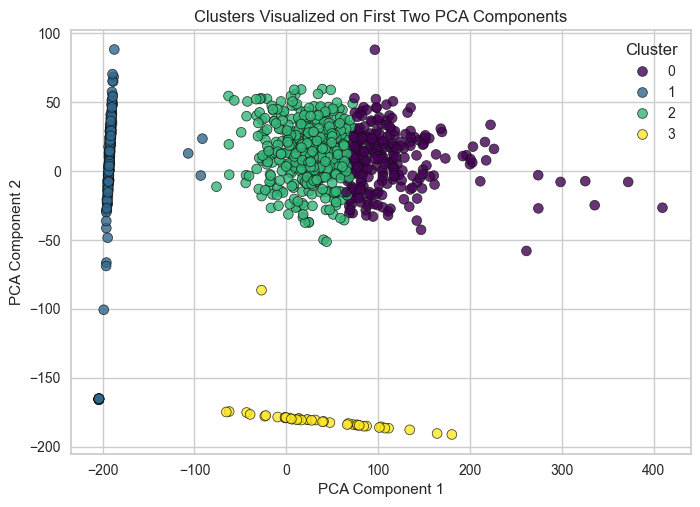

**Figure B**<br>
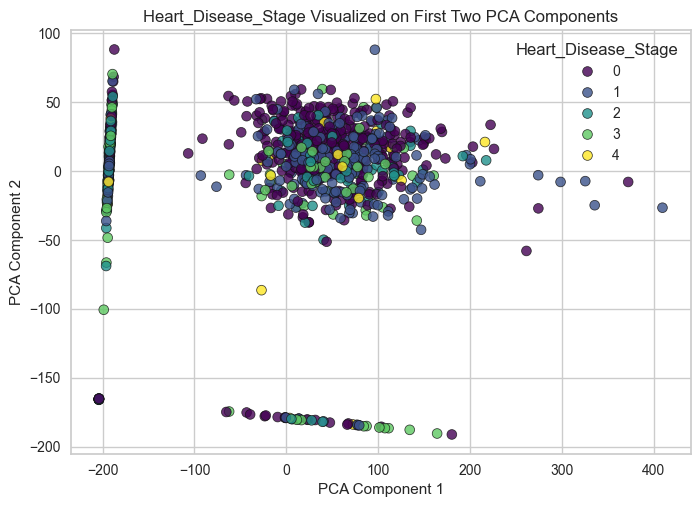

Below code just excluded Heart_Disease_Stage. I didn`t exclude the variable running Cluster.

## Q3. Redo the analyses (Clustering and PCA) by excluding Heart_Disease_Stage. a) run Clustering analysis and 2)PCA without Cluster variable and Heart_Disease_Stage. You will use the computed clusters only for colour coding in your plots.

1) run clustering analysis

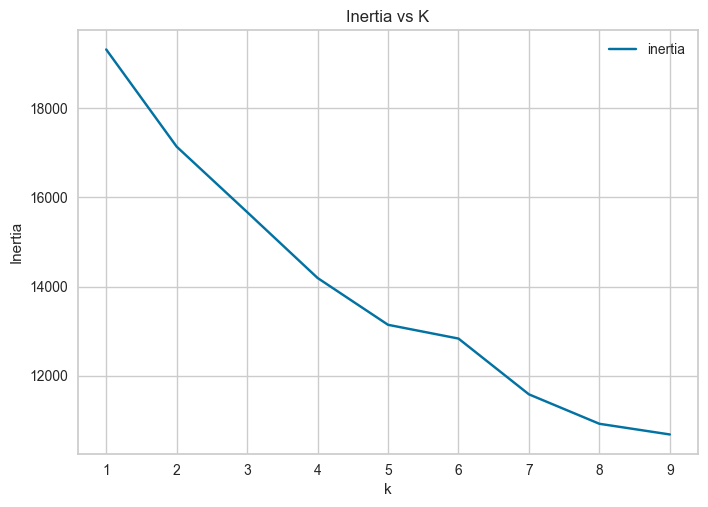

Analysis: It's not obvious where the elbow is (maybe 5 or 7?) so I'll use yellowbrick to select K


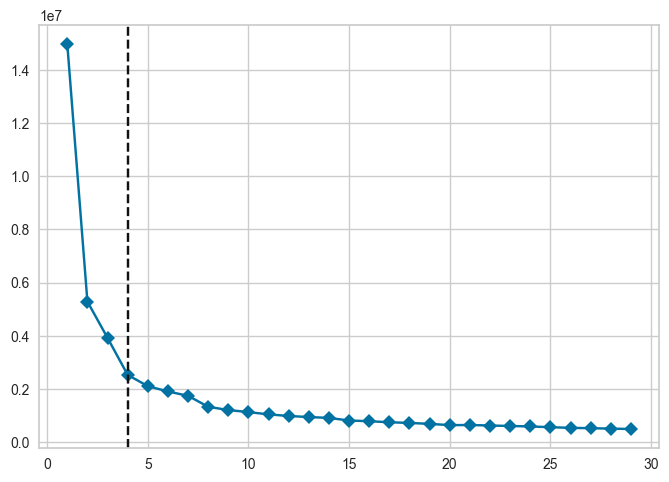

Analysis: Based on this plot, it appears that the optimal K is 4.
I'll use the yellowbricks selection going forward.


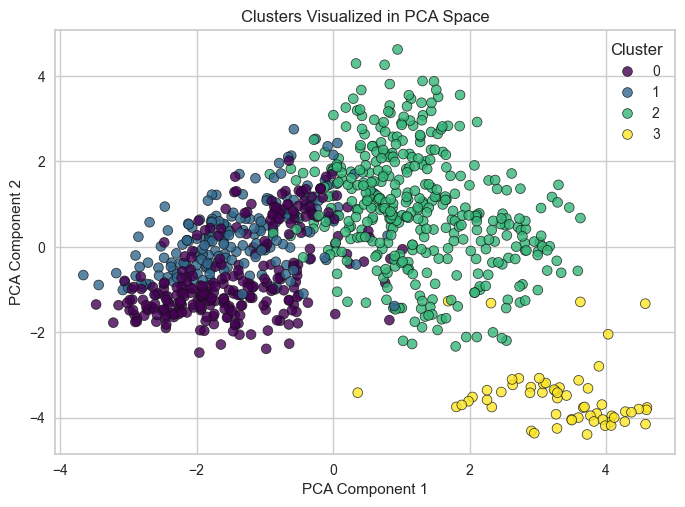

In [138]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# ============================
# Load and Prepare the Dataset
# ============================
data = pd.read_csv('heart_disease_uci.csv').set_index('id')

# Rename 'num' column to 'Heart_Disease_Stage'
data.rename({'num': 'Heart_Disease_Stage'}, axis=1, inplace=True)

# Replace spaces in column names with underscores
data.columns = data.columns.str.replace(' ', '_')

# ============================
# One-Hot Encoding for Categorical Variables
# ============================
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Fill

### Data Prep
# Handle missing data
data_encoded = data_encoded.fillna(0)

# Split into X and remove the target varible
X = data_encoded.drop(columns=['Heart_Disease_Stage'])

# Standardize/normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

### Clustering
# Get optimal K
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append({
        'k': k,
        'inertia': kmeans.inertia_
    })
inertia_df = pd.DataFrame(data=inertia, columns=['k', 'inertia']).set_index('k')
ax = inertia_df.plot()
ax.set_title('Inertia vs K')
ax.set_xlabel('k')
ax.set_ylabel('Inertia')
plt.show()
print("Analysis: It's not obvious where the elbow is (maybe 5 or 7?) so I'll use yellowbrick to select K")

## Find optimal K with yellowbrick
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 30), metric='distortion', timings=False)
visualizer.fit(data_encoded)
plt.show()
print("Analysis: Based on this plot, it appears that the optimal K is 4.")
print("I'll use the yellowbricks selection going forward.")

# Run KMeans for best k and save clusters and assign clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled_df)

### PCA
# I use PCA to see which features most impact Y (explain X percent of variance)
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled_df)
X_pca_df = pd.DataFrame(
    X_pca, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_scaled_df.columns
)

## VISUALIZE
# Plot Principal Component (PC) 1 vs PC 2 with cluster assignment
sns.scatterplot(
    x=X_pca_df.iloc[:, 0], 
    y=X_pca_df.iloc[:, 1], 
    hue=clusters, 
    palette='viridis', 
    alpha=0.8, 
    edgecolor='k'
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualized in PCA Space")
plt.legend(title="Cluster")
plt.show()

We'll use k=4

In [139]:
# Run K-means
optimal_clusters = 4  # Based on elbow/dendrogram
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_encoded['Cluster'] = kmeans.fit_predict(data_encoded)
data_encoded.head()

,age,trestbps,chol,thalch,oldpeak,ca,Heart_Disease_Stage,sex_Male,dataset_Hungary,dataset_Switzerland,...,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect,Cluster
id,,,,,,,,,,,,,,,,,,,,,
1,63,145.000000,233.000000,150.000000,2.300000,0.000000,0,True,False,False,...,True,True,False,False,False,False,False,False,False,2
2,67,160.000000,286.000000,108.000000,1.500000,3.000000,2,True,False,False,...,False,False,False,False,True,True,False,True,False,0
3,67,120.000000,229.000000,129.000000,2.600000,2.000000,1,True,False,False,...,False,False,False,False,True,True,False,False,True,2
4,37,130.000000,250.000000,187.000000,3.500000,0.000000,0,True,False,False,...,False,False,True,False,False,False,False,True,False,2
5,41,130.000000,204.000000,172.000000,1.400000,0.000000,0,False,False,False,...,False,False,False,False,False,False,True,True,False,2


2) PCA without Cluster variable and Heart_Disease_Stage.

In [140]:
# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(data_encoded.drop(columns=['Heart_Disease_Stage', 'Cluster']))

# Explained Variance Ratio (Individual & Cumulative)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

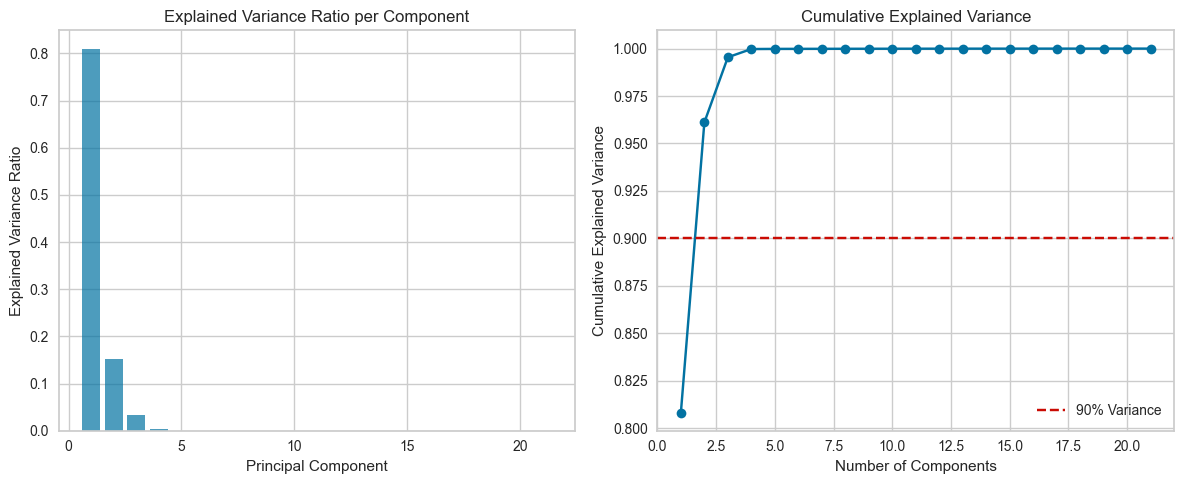

In [141]:
# Plot: Explained Variance for Each Component
plt.figure(figsize=(12, 5))

# Subplot 1: Individual Explained Variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Component')

# Subplot 2: Cumulative Explained Variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [142]:
# Create a DataFrame for PCA Loadings
loadings_df = pd.DataFrame(
    pca.components_,  # PCA loadings (eigenvectors)
    columns=data_encoded.drop(columns=['Heart_Disease_Stage', 'Cluster']).columns,  # Original feature names (excluding Cluster)
    index=[f'PC{i+1}' for i in range(len(pca.components_))]  # Naming PCs
)

# Identify the feature with the highest absolute contribution to PC1
top_feature_pc1 = loadings_df.loc['PC1'].abs().idxmax()

# ============================
# Display PCA Loadings & Top Contributor to PC1
# ============================
print("PCA Loadings for PC1:")
print(loadings_df.loc['PC1'])
print(f"\nFeature with highest contribution to PC1: {top_feature_pc1}")

PCA Loadings for PC1:
age                        -0.006220
trestbps                    0.031253
chol                        0.997607
thalch                      0.061295
oldpeak                     0.000670
ca                          0.000934
sex_Male                   -0.000660
dataset_Hungary             0.000961
dataset_Switzerland        -0.001956
dataset_VA Long Beach      -0.000386
cp_atypical angina          0.000413
cp_non-anginal             -0.000047
cp_typical angina           0.000056
fbs_True                    0.000260
restecg_normal             -0.000241
restecg_st-t abnormality   -0.000417
exang_True                 -0.000040
slope_flat                  0.000029
slope_upsloping             0.000081
thal_normal                 0.000486
thal_reversable defect     -0.000166
Name: PC1, dtype: float64

Feature with highest contribution to PC1: chol


Based on the PCA, we see that chol, or serum cholesterol in mg/dl explains 99% of the variance.

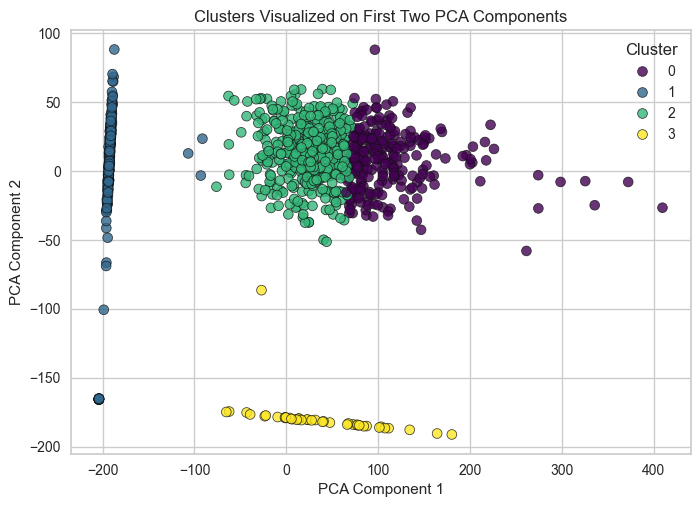

In [143]:
pca_2d = pca_features[:, :2]  # Use first two principal components
cluster_labels = data_encoded['Cluster']  # Store for visualization
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=cluster_labels, palette='viridis', alpha=0.8, edgecolor='k')
plt.title('Clusters Visualized on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

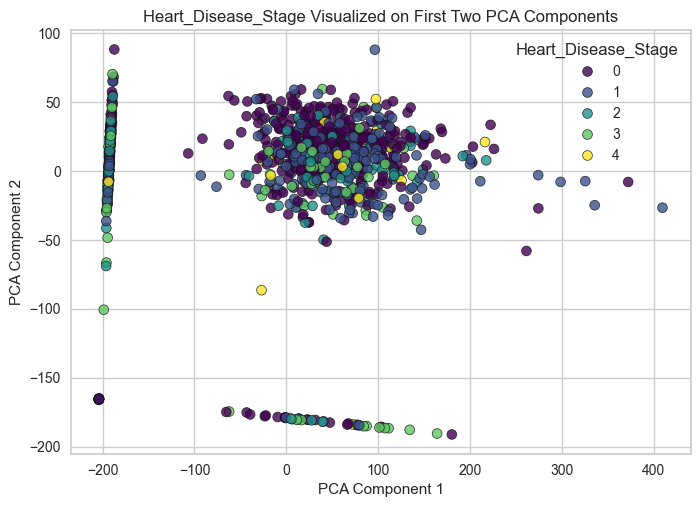

In [144]:

pca_2d = pca_features[:, :2]  # Use first two principal components
cluster_labels = data_encoded['Heart_Disease_Stage']  # Store for visualization
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=cluster_labels, palette='viridis', alpha=0.8, edgecolor='k')
plt.title('Heart_Disease_Stage Visualized on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Heart_Disease_Stage')
plt.show()